In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
base_dir = 'times'
figures_dir = 'figures'
hosts = ['Carls-MBP.home']
hosts_labels = ['MacBook Pro']
sizes = ['small', 'medium']
benchmarks = []
#hosts = ['iw5', 'threadripper00', 'threadripper02']
#hosts_labels = ['Intel W5-2445', 'AMD Threadripper 1950X', 'AMD Threadripper 7975WX']
#sizes = ['small', 'medium', 'large']
#benchmarks = ['full', 'partial', 'no', 'metadata']
benchmarks_labels = ['Full restore', 'Partial restore', 'No restore', 'Metadata only']
legacies = ['true', 'false']
sparsity_size = 'medium'

# Load the regular runs
runs = dict()
for host in hosts:
    runs[host] = dict()
    for size in sizes:
        runs[host][size] = dict()
        for benchmark in benchmarks:
            runs[host][size][benchmark] = dict()
            for legacy in legacies:
                with open(f'{base_dir}/{host}_{size}_{benchmark}_{legacy}.csv', 'r') as f:
                    lines = np.array([float(line.strip()) for line in f.readlines()])
                    runs[host][size][benchmark][legacy] = lines

# Load the sparsity runs
for host in hosts:
    runs[host][sparsity_size] = dict()
    runs[host][sparsity_size]['sparse'] = dict()
    for legacy in legacies:
        runs[host][sparsity_size]['sparse'][legacy] = dict()
        with open(f'{base_dir}/{host}_{sparsity_size}_sparse_{legacy}.csv', 'r') as f:
            lines = np.array([[float(elem) for elem in line.strip().split(';')] for line in f.readlines()])
            runs[host][sparsity_size]['sparse'][legacy] = lines

In [ ]:
def clean(times):
    no_outliers = np.sort(times)[1:-1]
    return np.mean(no_outliers), np.min(no_outliers), np.max(no_outliers)

def plot_bars_regular(runs, host, size, host_label):
    width = .2
    off = -width
    super_means = []
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for l in legacies:
        means = []
        mins = []
        maxs = []
        for b in benchmarks:
            mean, mi, ma = clean(runs[host][size][b][l])
            means.append(mean)
            mins.append(mi)
            maxs.append(ma)

        super_means.append(np.mean(means))
        means = np.array(means)
        mins = np.array(mins)
        maxs = np.array(maxs)

        plt.bar(np.arange(len(benchmarks)) + off, means, yerr=[means-mins, maxs-means], capsize=5, width=.2, label='Legacy' if l == 'true' else 'New', zorder=3)
        off += width
    plt.legend()

    plt.hlines(super_means[0], -.5, len(benchmarks)-.5, colors=colors[0], alpha=.5, linestyles='dashed', label='Legacy mean', zorder=4)
    plt.hlines(super_means[1], -.5, len(benchmarks)-.5, colors=colors[1], alpha=.5, linestyles='dashed', label='New mean', zorder=4)

    # Highlight the difference between the two means
    plt.annotate('', xy=(3.3, super_means[1]), xytext=(3.3, super_means[0]), arrowprops=dict(arrowstyle='<->', color='black'))
    plt.text(3.6, (super_means[0]+super_means[1])/2, f'Difference:\n{np.abs(super_means[1]-super_means[0]):.2f} ms\n\n~{super_means[0]/super_means[1]:.2f} x', verticalalignment='center', horizontalalignment='left')

    plt.xticks(np.arange(len(benchmarks))-.5*width, benchmarks_labels)
    plt.xlim(-.5, len(benchmarks)-.5)
    plt.ylabel('Time (ms)')
    plt.xlabel('Benchmark')
    plt.title(f'Execution time for the {size} benchmark on {host_label}')
    plt.grid(axis='y', alpha=.25, zorder=0)

plot_bars_regular(runs, hosts[0], 'small', hosts_labels[0])
plt.show()

KeyError: 'true'

In [ ]:
if not os.path.exists(figures_dir):
    os.mkdir(figures_dir)

for host, host_label in zip(hosts, hosts_labels):
    for size in sizes:
        plot_bars_regular(runs, host, size, host_label)
        # More horizontal space for the legend
        plt.tight_layout(rect=[0, 0, 1, .9])
        plt.savefig(f'{figures_dir}/{host}_{size}.png', dpi=300)
        plt.clf()

<Figure size 640x480 with 0 Axes>

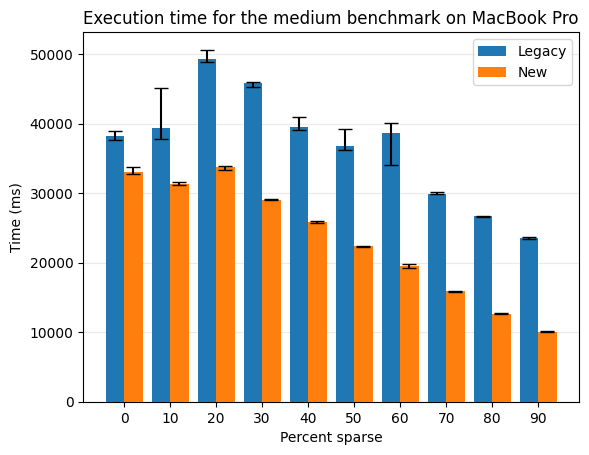

In [4]:
def plot_bars_sparse(runs, host, host_label):
    width = 4
    off = -(.5*width)

    for l in legacies:
        measured = runs[host][sparsity_size]['sparse'][l]
        measured = np.sort(measured, axis=1)
        measured = measured[:, 1:-1]
        means = np.mean(measured, axis=1)
        mins = np.min(measured, axis=1)
        maxs = np.max(measured, axis=1)

        plt.bar((np.arange(10) * 10) + off, means, yerr=[means-mins, maxs-means], capsize=5, width=width, label='Legacy' if l == 'true' else 'New', zorder=3)
        off += width
    plt.legend()


    plt.xticks(np.arange(10) * 10)
    #plt.xlim(-.5, len(benchmarks)-.5)
    plt.ylabel('Time (ms)')
    plt.xlabel('Percent sparse')
    plt.title(f'Execution time for the {size} benchmark on {host_label}')
    plt.grid(axis='y', alpha=.25, zorder=0)

plot_bars_sparse(runs, hosts[0], hosts_labels[0])
plt.show()